## Dependencies


In [3]:
import pandas as pd
import numpy as np

## Read & clean data from Excel


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820 entries, 0 to 819
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Census Tract     820 non-null    float64
 1   2024 Median Age  820 non-null    float64
dtypes: float64(2)
memory usage: 12.9 KB


array([[<Axes: title={'center': '2024 Median Age'}>]], dtype=object)

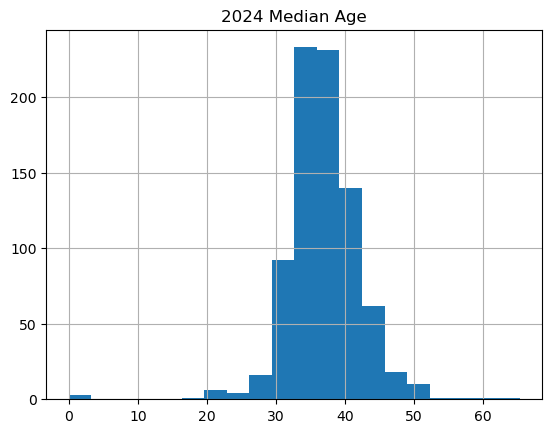

In [13]:
# read_excel function
median_age = pd.read_excel('Data/median_age.xlsx', engine='openpyxl')

# use 'type' function to see what we're working with
type(median_age)

# use 'info' & 'describe' methods to find out about the dataframe
median_age.info()
median_age.describe()

# use 'astype' to change the Census Tract data type
median_age['Census Tract'] = median_age['Census Tract'].astype('str')

# remove the decimal from Census Tract column
median_age['Census Tract'] = median_age['Census Tract'].str.replace('.', '')

# show histogram
median_age.hist(bins=20)

## Read & clean data from CSV


#### Scrub the data


In [92]:
# read_csv function
migration_df = pd.read_csv(
    'Data/countyinflow2122.csv',
    usecols=['y2_countyfips', 'y2_statefips',
             'y1_countyfips', 'y1_statefips', 'n2', 'agi']
)

# because the y1, y2 designations are confusing, replace these with 'origin' and 'dest'
new_columns = {
    col: col.replace('y1', 'origin', 1).replace('y2', 'dest', 1)
    for col in migration_df.columns
}
migration_df = migration_df.rename(columns=new_columns)

# because 'agi' is in thousands, multiply column by 1,000
migration_df['agi'] = migration_df['agi'] * 1000

# rename 'n2' column
migration_df = migration_df.rename(columns={'n2': 'persons'})

# create full FIPS codes for origin, destination
migration_df['dest_FIPS'] = migration_df['dest_statefips'].astype(
    str).str.zfill(2) + migration_df['dest_countyfips'].astype(str).str.zfill(3)
migration_df['orig_FIPS'] = migration_df['origin_statefips'].astype(
    str).str.zfill(2) + migration_df['origin_countyfips'].astype(str).str.zfill(3)

# reduce the number of columns we need
migration_df = migration_df[[
    'orig_FIPS',
    'dest_FIPS',
    'persons',
    'agi'
]]

# how to just show Fulton County?
migration_df[migration_df['orig_FIPS'] == '13121']

,orig_FIPS,dest_FIPS,persons,agi
31,13121,01003,61,5179000
294,13121,01073,253,20702000
411,13121,01081,113,5717000
484,13121,01089,80,4565000
588,13121,01097,94,2639000
...,...,...,...,...
52135,13121,53033,434,42449000
52709,13121,53053,36,1228000
52840,13121,53061,46,3815000
53636,13121,55025,31,2955000


#### Lookup county names from FIPS code


In [177]:
# read in CSV to use as dataframe lookup table
lookup_df = pd.read_csv('Data/FIPS_lookup.csv', dtype={'FIPS': 'str'})

# ensure FIPS codes are properly zero-padded
lookup_df['FIPS'] = lookup_df['FIPS'].str.zfill(5)

# Merge to get origin county names
migration_2 = migration_df.merge(
    lookup_df[['FIPS', 'County_name', 'State']],
    how='left',
    left_on='orig_FIPS',
    right_on='FIPS'
).rename(columns={'County_name': 'orig_county', 'State': 'orig_state'})

# Drop the extra FIPS column
migration_2.drop(columns=['FIPS'], inplace=True)

# Merge to get destination county names
migration_final = migration_2.merge(
    lookup_df[['FIPS', 'County_name', 'State']],
    how='left',
    left_on='dest_FIPS',
    right_on='FIPS'
).rename(columns={'County_name': 'dest_county', 'State': 'dest_state'})

# Drop the extra FIPS column
migration_final.drop(columns=['FIPS'], inplace=True)

# rearrange the columns
migration_final = migration_final[[
    'orig_FIPS',
    'orig_county',
    'orig_state',
    'persons',
    'agi',
    'dest_FIPS',
    'dest_county',
    'dest_state'
]]

migration_final.sample(10)

,orig_FIPS,orig_county,orig_state,persons,agi,dest_FIPS,dest_county,dest_state
12972,13135,Gwinnett,Georgia,119,10113000,12109,St. Johns,Florida
37969,40105,Nowata,Oklahoma,50,1152000,40143,Tulsa,Oklahoma
17738,17019,Champaign,Illinois,177,4364000,17053,Ford,Illinois
1967,41051,Multnomah,Oregon,41,2208000,04025,Yavapai,Arizona
33699,37191,Wayne,North Carolina,49,1289000,37063,Durham,North Carolina
2806,06085,Santa Clara,California,172,9740000,06007,Butte,California
25557,06073,San Diego,California,69,1888000,27003,Anoka,Minnesota
9912,12099,Palm Beach,Florida,333,8879000,12051,Hendry,Florida
49318,35045,San Juan,New Mexico,43,985000,49035,Salt Lake,Utah
30877,35055,Taos,New Mexico,95,4759000,35049,Santa Fe,New Mexico


#### Get metro Atlanta counties


In [96]:
# read in 29 counties from Wikipedia
url = "https://en.wikipedia.org/wiki/Metro_Atlanta"

# use 'read_html' to get the data
atl_df = pd.read_html(url)

atl_df[4]

,County,Seat,2020 census,2010 census,Change,Area,Density
0,Fulton *,Atlanta,1066710,920581,+15.87%,"534 sq mi (1,380 km2)",2)
1,Gwinnett *,Lawrenceville,957062,805321,+18.84%,"437 sq mi (1,130 km2)",2)
2,Cobb *,Marietta,766149,688078,+11.35%,345 sq mi (890 km2),2)
3,DeKalb *,Decatur,764382,691893,+10.48%,271 sq mi (700 km2),2)
4,Clayton *,Jonesboro,297595,259424,+14.71%,144 sq mi (370 km2),2)
5,Cherokee *,Canton,266620,214346,+24.39%,"434 sq mi (1,120 km2)",2)
6,Forsyth *,Cumming,251283,175511,+43.17%,224 sq mi (580 km2),2)
7,Henry *,McDonough,240712,203922,+18.04%,327 sq mi (850 km2),2)
8,Paulding *,Dallas,168661,142324,+18.50%,314 sq mi (810 km2),2)
9,Coweta *,Newnan,146158,127317,+14.80%,"446 sq mi (1,160 km2)",2)


#### Clean metro county list


In [188]:
# pare down the dataframe
atl_df_clean = atl_df[4][[
    'County'
]]

# remove the last row, which totals the counties
atl_df_clean = atl_df_clean[atl_df_clean['County'] != 'Total']

# remove the " *" from the 'County' column
atl_df_clean['County'] = atl_df_clean['County'].str.replace(
    ' *', '', regex=False)

# add the state
atl_df_clean['State'] = 'Georgia'

# add the FIPS code
fips_df = pd.read_csv('Data/FIPS_lookup.csv')
fips_df['FIPS'] = fips_df['FIPS'].astype(str).str.zfill(5)

# merge the ATL dataframe with the FIPS lookup table
atl_df_clean = atl_df_clean.merge(
    fips_df,
    how='left',
    left_on=['County', 'State'],
    right_on=['County_name', 'State'],
).drop(columns='County_name')

# convert the FIPS values to a list
atl_fips = list(atl_df_clean['FIPS'])
atl_fips

['13121',
 '13135',
 '13067',
 '13089',
 '13063',
 '13057',
 '13117',
 '13151',
 '13223',
 '13077',
 '13097',
 '13113',
 '13045',
 '13217',
 '13015',
 '13297',
 '13247',
 '13013',
 '13255',
 '13187',
 '13227',
 '13143',
 '13085',
 '13035',
 '13199',
 '13211',
 '13231',
 '13159',
 '13149']

#### Only get migration into / out of metro ATL counties


In [218]:
# filter the migration dataset to only include ATL counties
migration_atl = migration_final[migration_final['orig_FIPS'].isin(atl_fips) |
                                migration_final['dest_FIPS'].isin(atl_fips)]

# print out rows in the dataframe
print(migration_atl.shape[0])
migration_atl.sample(10)

2359


,orig_FIPS,orig_county,orig_state,persons,agi,dest_FIPS,dest_county,dest_state
14335,48113,Dallas,Texas,37,534000,13063,Clayton,Georgia
4624,13121,Fulton,Georgia,239,28813000,06073,San Diego,California
15516,25009,Essex,Massachusetts,48,2040000,13135,Gwinnett,Georgia
25434,13089,DeKalb,Georgia,100,2015000,26163,Wayne,Michigan
14216,12099,Palm Beach,Florida,68,5140000,13057,Cherokee,Georgia
14940,13097,Douglas,Georgia,90,3380000,13113,Fayette,Georgia
16313,13057,Cherokee,Georgia,60,4169000,13291,Union,Georgia
15506,37067,Forsyth,North Carolina,43,988000,13135,Gwinnett,Georgia
15544,13127,Glynn,Georgia,45,1793000,13135,Gwinnett,Georgia
15619,13089,DeKalb,Georgia,2133,50431000,13151,Henry,Georgia


## Pandas rapid fire


#### 1st dataset


In [235]:
# make the dataset
data = {
    'animal': ['cat', 'cat', 'snake', 'dog', 'dog', 'cat', 'snake', 'cat', 'dog', 'dog'],
    'age': [2.5, 3, 0.5, np.nan, 5, 2, 4.5, np.nan, 7, 3],
    'visits': [1, 3, 2, 3, 2, 3, 1, 1, 2, 1],
    'priority': ['yes', 'yes', 'no', 'yes', 'no', 'no', 'no', 'yes', 'no', 'no']
}

df = pd.DataFrame(data)

df

,animal,age,visits,priority
0,cat,2.5,1,yes
1,cat,3.0,3,yes
2,snake,0.5,2,no
3,dog,NaN,3,yes
4,dog,5.0,2,no
5,cat,2.0,3,no
6,snake,4.5,1,no
7,cat,NaN,1,yes
8,dog,7.0,2,no
9,dog,3.0,1,no


In [236]:
# select rows where the age is missing
df[df['age'].isnull()]

,animal,age,visits,priority
3,dog,NaN,3,yes
7,cat,NaN,1,yes


In [241]:
# Select the rows the age is between 2 and 4 (inclusive)
df[(df['age'] >= 2) & (df['age'] <= 4)]

# df[df['age'].between(2, 4)]

,animal,age,visits,priority
0,cat,2.5,1,yes
1,cat,3.0,3,yes
5,cat,2.0,3,no
9,dog,3.0,1,no


In [249]:
# Explore the 'nunique', 'unique', and 'value_counts' methods for the 'animal' column
df['animal'].value_counts()

animal
cat      4
dog      4
snake    2
Name: count, dtype: int64

In [253]:
# For each unique animal, calculate the median age
df.groupby('animal')['age'].mean()

animal
cat      2.5
dog      5.0
snake    2.5
Name: age, dtype: float64

In [257]:
# Sort df first by the values in the 'age' in decending order, then by the value in the 'visits' column in ascending order
df.sort_values(by=['age', 'visits'], ascending=[False, True])

,animal,age,visits,priority
8,dog,7.0,2,no
4,dog,5.0,2,no
6,snake,4.5,1,no
9,dog,3.0,1,no
1,cat,3.0,3,yes
0,cat,2.5,1,yes
5,cat,2.0,3,no
2,snake,0.5,2,no
7,cat,NaN,1,yes
3,dog,NaN,3,yes


#### 2nd dataset


In [309]:
# Which column of the following numbers has the largest, smallest sum?
data = {
    'A': [45, 67, 23, 89, 12],
    'B': [78, 34, 56, 90, 21],
    'C': [98, 23, 54, 65, 76],
    'D': [12, 34, 87, 45, 68],
    'E': [34, 89, 76, 54, 32],
    'F': [56, 78, 90, 12, 34]
}

df = pd.DataFrame(data)

df.sum()
df.sum().sort_values(ascending=False)
df.min().idxmax()

A    12
B    21
C    23
D    12
E    32
F    12
dtype: int64

In [9]:
# For each group, find the sum of the three greatest values
df = pd.DataFrame({
    'groups': list('aaabbcaabcccbbc'),
    'vals': [12, 345, 3, 1, 45, 14, 4, 52, 54, 23, 235, 21, 57, 3, 87]
})

# step 1
df.groupby('groups')['vals'].nlargest(3)

# step 3
# df.groupby('groups')['vals'].apply(lambda x: x.nlargest(3).sum())

groups    
a       1     345
        7      52
        0      12
b       12     57
        8      54
        4      45
c       10    235
        14     87
        9      23
Name: vals, dtype: int64